load datasets from kaggle 

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

before first line you need to import kaggle.json into filesystem



In [ ]:
# google colab
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle competitions download cifar-10
#!unzip cifar-10.zip

In [1]:
#kaggle notebook
!pip install torchsummary
!pip install --upgrade torch torchvision

     |████████████████████████████████| 750.6 MB 9.4 kB/s              | 422.1 MB 62.0 MB/s eta 0:00:06    |███████████████████▉            | 464.7 MB 28.4 MB/s eta 0:00:11��         | 519.2 MB 31.0 MB/s eta 0:00:08��████████▌   | 667.4 MB 27.2 MB/s eta 0:00:04
     |████████████████████████████████| 21.0 MB 39.2 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.5.3 requires torch<1.11,>=1.7.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.9.1 requires torch<1.11.0,>=1.6.0, but you have torch 1.11.0 which i

In [2]:
!pip install py7zr

     |████████████████████████████████| 76 kB 901 kB/s            
     |████████████████████████████████| 357 kB 1.8 MB/s            
     |████████████████████████████████| 2.4 MB 19.5 MB/s            
     |████████████████████████████████| 43 kB 1.4 MB/s             
     |████████████████████████████████| 57 kB 4.7 MB/s             
     |████████████████████████████████| 131 kB 62.6 MB/s            
     |████████████████████████████████| 2.0 MB 62.3 MB/s            


In [3]:
#!python -m py7zr x ./train.7z # colab 
!python -m py7zr x ../input/cifar-10/train.7z #kaggle notebook

In [45]:
#!python -m py7zr x ./test.7z
!python -m py7zr x ../input/cifar-10/test.7z #kaggle notebook

In [4]:
#imports
import math
import random
import copy
import os

import pandas as pd
import numpy as np

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary
from torchvision import models

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm


In [5]:
#variable
IMG_SIZE = 32

In [6]:
hyp = {
    #regularization hyperparameters
    "dropout_rate" : 0.2,
    "data_augmentation_rate" : 0.06, # probabilty of any transformation = 1 - (1 - data_augmentation_rate)**(Number of transformation)
    "data_augmentation_rate_mix" : 0.03,



    #leraning hyperparameters
    "batch_size" : 256,
    "lerning_rate" :  1e-3,
    "shuffle" : True
}


In [7]:
class CustomImageDataset(Dataset):
    def __init__(self,  img_dir,annotations_file = None,transform = None):
      self.img_labels = None
      self.le = preprocessing.LabelEncoder()
      if  annotations_file is not None:
        self.img_labels = pd.read_csv(annotations_file)
        self.img_labels['index_label'] = self.le.fit_transform(self.img_labels.iloc[:,1])
      self.img_dir = img_dir
      self.transform = transform

    def __len__(self):
      if self.img_labels is None:
        return len(os.listdir(self.img_dir))
      return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(idx + 1) + '.png')
        image = read_image(img_path)
        label = F.one_hot(torch.tensor(1),10).float()
        if  self.img_labels is not None:
          label = self.img_labels.iloc[idx, 2]
          label = torch.tensor(int(label))
          label = F.one_hot(label,10).float()

        # apply transformations
        if self.transform:
          for t in self.transform:
            image = t(image)
        return image, label
          
    def getLabel(self,idx):
      if  self.img_labels is not None:
        return self.img_labels.iloc[idx,1]
      return None

    def encodeLabel(self, idx):
      if self.img_labels is None:
        return None
      return self.le.inverse_transform(idx)

In [8]:
class RandomProbabilityWrapper:

    def __init__(self,probability,transformation):
        self.transformation = transformation
        self.probability = probability


    def __call__(self, img):
        if random.random() < self.probability:
            return self.transformation(img)
        return img

In [9]:
class Cutmix:
  def __init__(self,probability, dataset):
    self.probability = probability
    self.dataset = dataset
    
  def transform(self, batch):
    indexes = np.where(np.random.rand(len(batch[0])) < self.probability)[0]
    print(indexes)
    for i in indexes:
        rand_index = random.randint(0,len(self.dataset) - 1 )
        second_image, second_label = self.dataset[rand_index]
        batch[0][i], batch[1][i] = self(batch[0][i], batch[1][i],second_image, second_label)
    return batch
    


  def __call__(self, image1, label1, image2, label2, beta_coff = 0.3,debug = False):
    ratio = np.random.beta(beta_coff, beta_coff, size=None)
    a = int(math.sqrt(ratio) * IMG_SIZE)
    x = random.randint(0, IMG_SIZE -1)
    y = random.randint(0, IMG_SIZE -1)
    x2 = x + a if x + a < IMG_SIZE else IMG_SIZE
    y2 = y + a if y + a < IMG_SIZE else IMG_SIZE
    width = x2 - x
    height = y2 - y
    ratio = width * height * 1.0 / (IMG_SIZE ** 2)

    crop2 = T.functional.crop(image2, y, x, height, width) #take only selected part 
    image2 = T.functional.pad(crop2, [x, y, IMG_SIZE - x2, IMG_SIZE - y2]) #set it on image dimenzions black image

    crop1 = T.functional.crop(image1, y, x, height, width)
    img1 = T.functional.pad(crop1, [x, y, IMG_SIZE - x2, IMG_SIZE - y2])

    image1 = image1 - img1
    image = image1 + image2

    label = ratio * label2 + (1 - ratio) * label1
    if debug == True:
        print("a = " + str(a))
        print("x, y = " +str(x) + ", "+str(y))
        print("x2, y2 = " +str(x2) + ", "+str(y2))
        print("width, height = " +str(width) + ", "+str(height))
        
    return image, label

In [10]:
class DataAugmentationLayer(nn.Module):
    def __init__(self, image_transformation = []):
        super().__init__()
        self.image_transformation = image_transformation

    def forward(self, x):
        if self.training == True:
            for t in self.image_transformation:
                x = t(x)          
        return x    

In [11]:
class TransformationLayer(nn.Module):
    def __init__(self, image_transformation = []):
        super().__init__()
        self.image_transformation = image_transformation

    def forward(self, x):
        for t in self.image_transformation:
            x = t(x)          
        return x    

In [12]:
#cifar10_dataset = CustomImageDataset("./train/","./trainLabels.csv") # google colab
cifar10_dataset = CustomImageDataset("./train/","../input/cifar-10/trainLabels.csv") #kaggle notebook

In [13]:
train_datasets, val_datasets = train_test_split(cifar10_dataset, test_size=0.2)

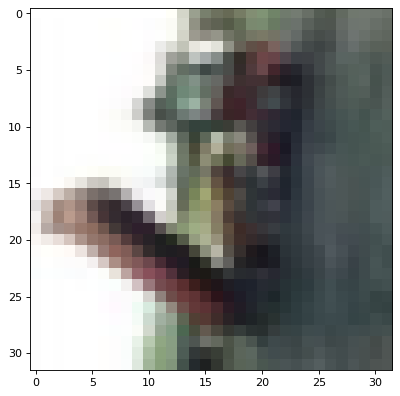

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
truck


In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
imgNum = 2
arr_ = cifar10_dataset[imgNum][0]
plt.imshow(arr_.T)
plt.show()
print(cifar10_dataset[imgNum][1])
print(cifar10_dataset.getLabel(imgNum))


In [16]:
rotation = RandomProbabilityWrapper(hyp["data_augmentation_rate"], lambda x : T.functional.rotate(x,int(np.random.choice([90,180,270]))))
resize_cropper = RandomProbabilityWrapper(hyp["data_augmentation_rate"], lambda x :T.RandomResizedCrop(size=(32, 32))(x))
affine = RandomProbabilityWrapper(hyp["data_augmentation_rate"], lambda x :T.RandomAffine(degrees=0, translate=(0.1, 0.4), scale=(1,1))(x))

cutmix = Cutmix(hyp["data_augmentation_rate_mix"],cifar10_dataset)

    

In [17]:
dataAugumentation = DataAugmentationLayer(image_transformation = [rotation,resize_cropper,affine])

In [18]:
train_dataloader = DataLoader(train_datasets, batch_size=hyp["batch_size"], shuffle=hyp["shuffle"])
val_dataloader = DataLoader(val_datasets, batch_size=hyp["batch_size"], shuffle=hyp["shuffle"])

a = 26
x, y = 30, 5
x2, y2 = 32, 31
width, height = 2, 26


Text(0.5, 1.0, "['tensor([0.0508, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,\\n        0.9492])--> truck']")

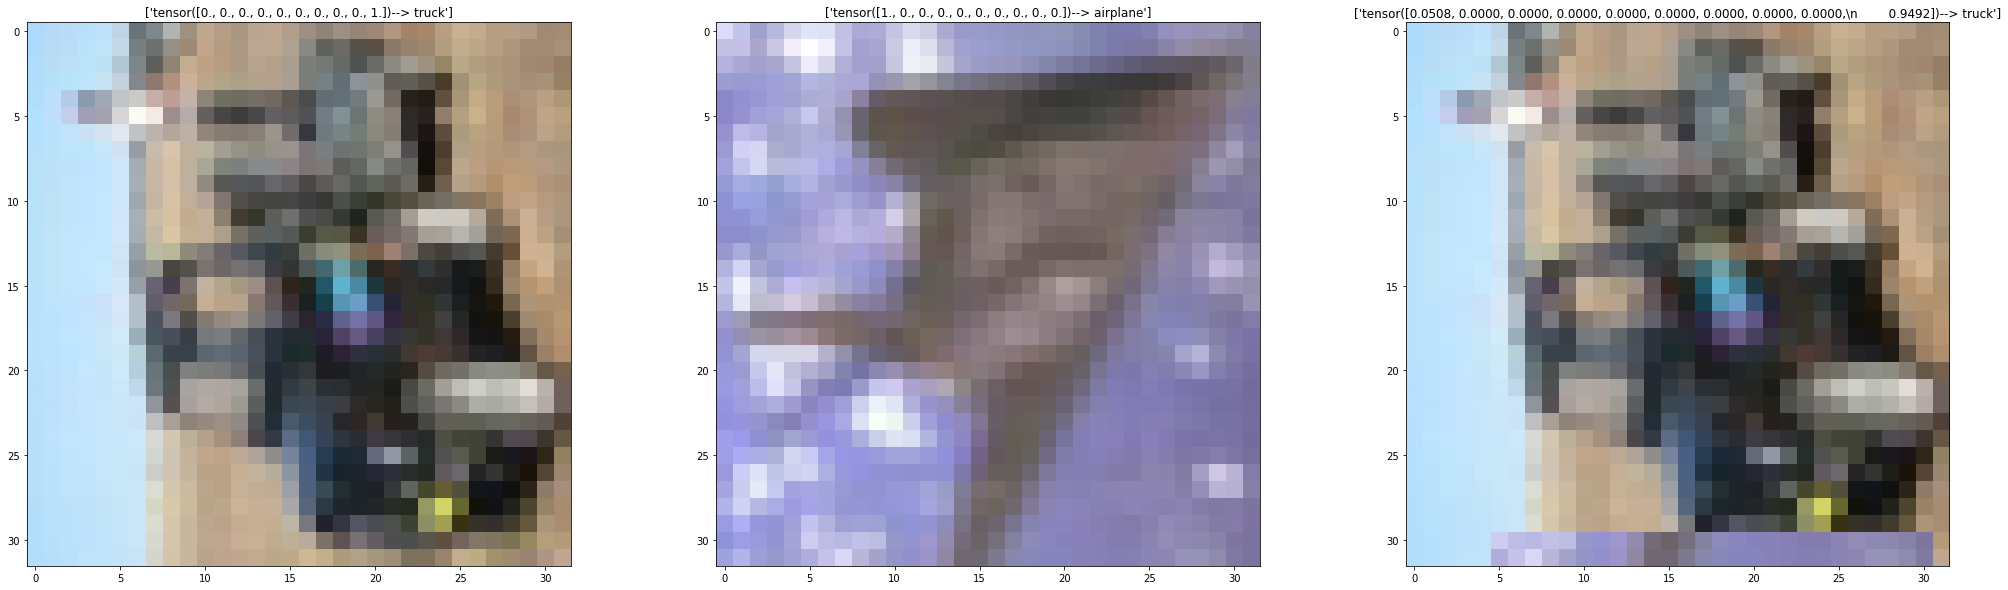

<Figure size 640x480 with 0 Axes>

In [22]:
imgNum = random.randint(0,len(cifar10_dataset))
imgNum1 =random.randint(0,len(cifar10_dataset))
figsize=(8, 6)
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(35, 10) )
i1,l1 = cifar10_dataset[imgNum]
ax1.imshow(i1.int().T)
ax1.set_title(str(l1) + "--> " + cifar10_dataset.encodeLabel([torch.argmax(l1)]))

i2,l2 = cifar10_dataset[imgNum1]
ax2.imshow(i2.int().T)
ax2.set_title(str(l2) + "--> " + cifar10_dataset.encodeLabel([torch.argmax(l2)]))


cut_test = Cutmix(1,cifar10_dataset)

figure(figsize=(8, 6), dpi=80)
image, label = cut_test(i1,l1,i2,l2,debug = True)
ax3.imshow(image.int().T)
ax3.set_title(str(label) + "--> " + cifar10_dataset.encodeLabel([torch.argmax(label)]))



In [23]:
def train(model, train_dataloader, test_dataloader = None, num_epochs=1, lr=1e-3, keepBest = False, mix_trainsformation = None):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  array_loss_train = np.empty([0])
  array_loss_val = np.empty([0])
  #with wandb.init(project="UZOP_LAB"):
  #model.cuda(0)
  best_model_wts = None
  best_lost = None

  for epoch in range(num_epochs):
    correct_train = 0
    model.train()
    with tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Training (epoch={epoch}/{num_epochs})') as epoch_progress:
      for batch_idx, train_batch in epoch_progress:
        if mix_trainsformation is not None:
            for t in mix_trainsformation:
                train_batch = t.transform(train_batch)
                
        x, y = train_batch      
        x = x.float().cuda()
        y = y.cuda()
        logits = model(x)
        value, predicted = torch.max(logits, 1)
        loss = F.cross_entropy(logits, y)
        epoch_correct = (predicted==torch.argmax(y, dim=1)).sum().item()
        correct_train += epoch_correct
        epoch_progress.set_postfix({'loss': 1 - epoch_correct / hyp["batch_size"]})  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = 1 - (correct_train / len(train_dataloader.dataset))
    array_loss_train = np.append(array_loss_train,train_loss)
    print("Train loss " + str(train_loss))

    if test_dataloader is not None: 
      with torch.no_grad():
        model.eval()
        correct_val = 0
        for test_batch in tqdm(test_dataloader, desc="Testing"):
          x, y = test_batch
          x = x.float().cuda()
          y = y.cuda()

          logits = model(x)
          value, predicted = torch.max(logits, 1)
          loss = F.cross_entropy(logits, y)
          epoch_correct = (predicted==torch.argmax(y, dim=1)).sum().item()
          correct_val += epoch_correct

        val_loss = 1 - (correct_val / len(test_dataloader.dataset))
        array_loss_val = np.append(array_loss_val,val_loss)
        print("Val loss " + str(val_loss))

      if best_lost is None or best_lost > val_loss:
            best_lost = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

  if test_dataloader is not None: 
    if keepBest:
        model.load_state_dict(best_model_wts)
      
    model.eval()
    
    with torch.no_grad():
      test_loss = []
      correct = 0
      count = 0


      for test_batch in tqdm(test_dataloader, desc="Testing"):
        x, y = test_batch
        x = x.float().cuda()
        y = y.cuda()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        test_loss.append(loss)
        correct += (logits.argmax(dim=-1) == torch.argmax(y, dim=1)).float().sum()
        count += len(y)

      test_loss = torch.mean(torch.tensor(test_loss))
      test_acc = correct / count

      # Log test metrics
      # wandb.log({"test/loss": test_loss, "test/acc": test_acc})

      print()
      print(f"--- TEST ---")
      print("loss: ", test_loss.item())
      print("accuracy: ", test_acc.item())
  
  model.train()
  return array_loss_train, array_loss_val

In [24]:
cnn_model5 = nn.Sequential(
                      dataAugumentation,
                      nn.Conv2d(3, 16, 3, 1, padding='same'),
                      nn.ReLU(),
                      nn.Dropout(hyp["dropout_rate"]),
                      nn.BatchNorm2d(16),
                      nn.Conv2d(16, 16, 3, 1, padding='same'),
                      nn.ReLU(),
                      nn.Dropout(hyp["dropout_rate"]),
                      nn.BatchNorm2d(16),
                      nn.MaxPool2d(2, 2),
                      

                      nn.Conv2d(16, 32, 3, 1, padding='same'),
                      nn.ReLU(),
                      nn.Dropout(hyp["dropout_rate"]),
                      nn.BatchNorm2d(32),
                      nn.Conv2d(32, 32, 3, 1, padding='same'),
                      nn.ReLU(),
                      nn.Dropout(hyp["dropout_rate"]),
                      nn.BatchNorm2d(32),
                      nn.MaxPool2d(2, 2),

                      nn.Conv2d(32, 64, 3, 1, padding='same'),
                      nn.ReLU(),
                      nn.Dropout(hyp["dropout_rate"]),
                      nn.BatchNorm2d(64),
                      nn.Conv2d(64, 64, 3, 1, padding='same'),
                      nn.ReLU(),
                      nn.Dropout(hyp["dropout_rate"]),
                      nn.BatchNorm2d(64),
                      nn.MaxPool2d(2, 2),

                      nn.Conv2d(64, 128, 3, 1, padding='same'),
                      nn.ReLU(),
                      nn.Dropout(hyp["dropout_rate"]),
                      nn.BatchNorm2d(128),
                      nn.Conv2d(128, 128, 3, 1, padding='same'),
                      nn.Dropout(hyp["dropout_rate"]),
                      nn.ReLU(),
                      nn.BatchNorm2d(128),
                      nn.MaxPool2d(2, 2),

                      nn.Flatten(start_dim=-3),
                      nn.Linear(512, 128),
                      nn.ReLU(),
                      nn.Dropout(hyp["dropout_rate"] + 0.1),
                      nn.Linear(128, 10),

                ).cuda()

In [25]:
summary(cnn_model5, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
DataAugmentationLayer-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             448
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
       BatchNorm2d-5           [-1, 16, 32, 32]              32
            Conv2d-6           [-1, 16, 32, 32]           2,320
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
       BatchNorm2d-9           [-1, 16, 32, 32]              32
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,640
             ReLU-12           [-1, 32, 16, 16]               0
          Dropout-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 

In [26]:
init_weights = copy.deepcopy(cnn_model5.state_dict())

In [27]:
tr_loss, val_los = train(cnn_model5, train_dataloader, val_dataloader,num_epochs=100, lr = hyp["lerning_rate"])

Training (epoch=0/100): 100%|██████████| 157/157 [00:02<00:00, 68.57it/s, loss=0.941]


Train loss 0.651625


Testing: 100%|██████████| 40/40 [00:00<00:00, 184.01it/s]


Val loss 0.7223999999999999


Training (epoch=1/100): 100%|██████████| 157/157 [00:02<00:00, 67.97it/s, loss=0.859]


Train loss 0.5270250000000001


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.08it/s]


Val loss 0.5256000000000001


Training (epoch=2/100): 100%|██████████| 157/157 [00:02<00:00, 68.30it/s, loss=0.852]


Train loss 0.4405


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.35it/s]


Val loss 0.48109999999999997


Training (epoch=3/100): 100%|██████████| 157/157 [00:02<00:00, 65.77it/s, loss=0.934]


Train loss 0.4002


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.66it/s]


Val loss 0.4366


Training (epoch=4/100): 100%|██████████| 157/157 [00:02<00:00, 68.25it/s, loss=0.832]


Train loss 0.379675


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.62it/s]


Val loss 0.38360000000000005


Training (epoch=5/100): 100%|██████████| 157/157 [00:02<00:00, 68.45it/s, loss=0.84] 


Train loss 0.3406


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.43it/s]


Val loss 0.44310000000000005


Training (epoch=6/100): 100%|██████████| 157/157 [00:02<00:00, 62.96it/s, loss=0.906]


Train loss 0.324225


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.56it/s]


Val loss 0.3155


Training (epoch=7/100): 100%|██████████| 157/157 [00:02<00:00, 64.94it/s, loss=0.836]


Train loss 0.33614999999999995


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.82it/s]


Val loss 0.38439999999999996


Training (epoch=8/100): 100%|██████████| 157/157 [00:02<00:00, 69.66it/s, loss=0.809]


Train loss 0.309125


Testing: 100%|██████████| 40/40 [00:00<00:00, 179.68it/s]


Val loss 0.28369999999999995


Training (epoch=9/100): 100%|██████████| 157/157 [00:02<00:00, 68.14it/s, loss=0.816]


Train loss 0.300675


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.14it/s]


Val loss 0.2823


Training (epoch=10/100): 100%|██████████| 157/157 [00:02<00:00, 68.56it/s, loss=0.902]


Train loss 0.275525


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.91it/s]


Val loss 0.25860000000000005


Training (epoch=11/100): 100%|██████████| 157/157 [00:02<00:00, 64.66it/s, loss=0.906]


Train loss 0.299125


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.47it/s]


Val loss 0.2852


Training (epoch=12/100): 100%|██████████| 157/157 [00:02<00:00, 69.49it/s, loss=0.812]


Train loss 0.27244999999999997


Testing: 100%|██████████| 40/40 [00:00<00:00, 178.76it/s]


Val loss 0.24739999999999995


Training (epoch=13/100): 100%|██████████| 157/157 [00:02<00:00, 68.28it/s, loss=0.828]


Train loss 0.26149999999999995


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.76it/s]


Val loss 0.26670000000000005


Training (epoch=14/100): 100%|██████████| 157/157 [00:02<00:00, 67.79it/s, loss=0.82] 


Train loss 0.268625


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.65it/s]


Val loss 0.2622


Training (epoch=15/100): 100%|██████████| 157/157 [00:02<00:00, 68.26it/s, loss=0.797]


Train loss 0.2501


Testing: 100%|██████████| 40/40 [00:00<00:00, 140.78it/s]


Val loss 0.26239999999999997


Training (epoch=16/100): 100%|██████████| 157/157 [00:02<00:00, 67.34it/s, loss=0.812]


Train loss 0.232425


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.30it/s]


Val loss 0.24850000000000005


Training (epoch=17/100): 100%|██████████| 157/157 [00:02<00:00, 69.22it/s, loss=0.809]


Train loss 0.24050000000000005


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.13it/s]


Val loss 0.23809999999999998


Training (epoch=18/100): 100%|██████████| 157/157 [00:02<00:00, 67.96it/s, loss=0.801]


Train loss 0.237425


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.24it/s]


Val loss 0.25949999999999995


Training (epoch=19/100): 100%|██████████| 157/157 [00:02<00:00, 63.15it/s, loss=0.809]


Train loss 0.23562499999999997


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.44it/s]


Val loss 0.21819999999999995


Training (epoch=20/100): 100%|██████████| 157/157 [00:02<00:00, 66.04it/s, loss=0.797]


Train loss 0.24444999999999995


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.31it/s]


Val loss 0.21309999999999996


Training (epoch=21/100): 100%|██████████| 157/157 [00:02<00:00, 69.30it/s, loss=0.809]


Train loss 0.22660000000000002


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.45it/s]


Val loss 0.22140000000000004


Training (epoch=22/100): 100%|██████████| 157/157 [00:02<00:00, 68.44it/s, loss=0.828]


Train loss 0.24239999999999995


Testing: 100%|██████████| 40/40 [00:00<00:00, 180.03it/s]


Val loss 0.24160000000000004


Training (epoch=23/100): 100%|██████████| 157/157 [00:02<00:00, 68.51it/s, loss=0.805]


Train loss 0.20840000000000003


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.21it/s]


Val loss 0.22319999999999995


Training (epoch=24/100): 100%|██████████| 157/157 [00:02<00:00, 65.40it/s, loss=0.809]


Train loss 0.23824999999999996


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.12it/s]


Val loss 0.2047


Training (epoch=25/100): 100%|██████████| 157/157 [00:02<00:00, 70.16it/s, loss=0.789]


Train loss 0.21699999999999997


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.73it/s]


Val loss 0.23360000000000003


Training (epoch=26/100): 100%|██████████| 157/157 [00:02<00:00, 68.42it/s, loss=0.797]


Train loss 0.22555000000000003


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.56it/s]


Val loss 0.22299999999999998


Training (epoch=27/100): 100%|██████████| 157/157 [00:02<00:00, 68.15it/s, loss=0.922]


Train loss 0.23240000000000005


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.99it/s]


Val loss 0.21819999999999995


Training (epoch=28/100): 100%|██████████| 157/157 [00:02<00:00, 65.68it/s, loss=0.797]


Train loss 0.21899999999999997


Testing: 100%|██████████| 40/40 [00:00<00:00, 150.03it/s]


Val loss 0.19879999999999998


Training (epoch=29/100): 100%|██████████| 157/157 [00:02<00:00, 68.83it/s, loss=0.789]


Train loss 0.220325


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.01it/s]


Val loss 0.22019999999999995


Training (epoch=30/100): 100%|██████████| 157/157 [00:02<00:00, 68.23it/s, loss=0.785]


Train loss 0.21230000000000004


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.96it/s]


Val loss 0.19720000000000004


Training (epoch=31/100): 100%|██████████| 157/157 [00:02<00:00, 67.97it/s, loss=0.797]


Train loss 0.2067


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.51it/s]


Val loss 0.2146


Training (epoch=32/100): 100%|██████████| 157/157 [00:02<00:00, 62.95it/s, loss=0.77]  


Train loss 0.2187


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.59it/s]


Val loss 0.21040000000000003


Training (epoch=33/100): 100%|██████████| 157/157 [00:02<00:00, 65.72it/s, loss=0.793]


Train loss 0.21155000000000002


Testing: 100%|██████████| 40/40 [00:00<00:00, 179.49it/s]


Val loss 0.19440000000000002


Training (epoch=34/100): 100%|██████████| 157/157 [00:02<00:00, 69.10it/s, loss=0.801]


Train loss 0.19272500000000004


Testing: 100%|██████████| 40/40 [00:00<00:00, 179.29it/s]


Val loss 0.21589999999999998


Training (epoch=35/100): 100%|██████████| 157/157 [00:02<00:00, 68.80it/s, loss=0.887] 


Train loss 0.21545000000000003


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.78it/s]


Val loss 0.1945


Training (epoch=36/100): 100%|██████████| 157/157 [00:02<00:00, 68.14it/s, loss=0.871]


Train loss 0.20445000000000002


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.96it/s]


Val loss 0.21909999999999996


Training (epoch=37/100): 100%|██████████| 157/157 [00:02<00:00, 66.50it/s, loss=0.793] 


Train loss 0.20240000000000002


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.62it/s]


Val loss 0.21809999999999996


Training (epoch=38/100): 100%|██████████| 157/157 [00:02<00:00, 68.70it/s, loss=0.789] 


Train loss 0.20767500000000005


Testing: 100%|██████████| 40/40 [00:00<00:00, 180.64it/s]


Val loss 0.20240000000000002


Training (epoch=39/100): 100%|██████████| 157/157 [00:02<00:00, 68.73it/s, loss=0.777]


Train loss 0.19282500000000002


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.51it/s]


Val loss 0.19630000000000003


Training (epoch=40/100): 100%|██████████| 157/157 [00:02<00:00, 68.28it/s, loss=0.789]


Train loss 0.189125


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.90it/s]


Val loss 0.21899999999999997


Training (epoch=41/100): 100%|██████████| 157/157 [00:02<00:00, 65.22it/s, loss=0.785]


Train loss 0.18935000000000002


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.08it/s]


Val loss 0.2146


Training (epoch=42/100): 100%|██████████| 157/157 [00:02<00:00, 68.95it/s, loss=0.824] 


Train loss 0.18022499999999997


Testing: 100%|██████████| 40/40 [00:00<00:00, 179.56it/s]


Val loss 0.235


Training (epoch=43/100): 100%|██████████| 157/157 [00:02<00:00, 68.58it/s, loss=0.777]


Train loss 0.19792500000000002


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.83it/s]


Val loss 0.2116


Training (epoch=44/100): 100%|██████████| 157/157 [00:02<00:00, 69.86it/s, loss=0.781] 


Train loss 0.19352499999999995


Testing: 100%|██████████| 40/40 [00:00<00:00, 180.34it/s]


Val loss 0.22950000000000004


Training (epoch=45/100): 100%|██████████| 157/157 [00:02<00:00, 62.30it/s, loss=0.801] 


Train loss 0.18874999999999997


Testing: 100%|██████████| 40/40 [00:00<00:00, 147.20it/s]


Val loss 0.20009999999999994


Training (epoch=46/100): 100%|██████████| 157/157 [00:02<00:00, 67.66it/s, loss=0.895] 


Train loss 0.17049999999999998


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.35it/s]


Val loss 0.20040000000000002


Training (epoch=47/100): 100%|██████████| 157/157 [00:02<00:00, 69.14it/s, loss=0.797] 


Train loss 0.18632499999999996


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.78it/s]


Val loss 0.19689999999999996


Training (epoch=48/100): 100%|██████████| 157/157 [00:02<00:00, 68.50it/s, loss=0.781]


Train loss 0.17825000000000002


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.54it/s]


Val loss 0.21719999999999995


Training (epoch=49/100): 100%|██████████| 157/157 [00:02<00:00, 68.00it/s, loss=0.781] 


Train loss 0.17955


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.49it/s]


Val loss 0.19630000000000003


Training (epoch=50/100): 100%|██████████| 157/157 [00:02<00:00, 66.50it/s, loss=0.898] 


Train loss 0.17900000000000005


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.97it/s]


Val loss 0.19799999999999995


Training (epoch=51/100): 100%|██████████| 157/157 [00:02<00:00, 68.94it/s, loss=0.789] 


Train loss 0.18562500000000004


Testing: 100%|██████████| 40/40 [00:00<00:00, 174.99it/s]


Val loss 0.20199999999999996


Training (epoch=52/100): 100%|██████████| 157/157 [00:02<00:00, 68.02it/s, loss=0.777] 


Train loss 0.199025


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.07it/s]


Val loss 0.21860000000000002


Training (epoch=53/100): 100%|██████████| 157/157 [00:02<00:00, 68.33it/s, loss=0.77]  


Train loss 0.18317499999999998


Testing: 100%|██████████| 40/40 [00:00<00:00, 178.14it/s]


Val loss 0.20820000000000005


Training (epoch=54/100): 100%|██████████| 157/157 [00:02<00:00, 64.21it/s, loss=0.781] 


Train loss 0.16117499999999996


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.78it/s]


Val loss 0.19720000000000004


Training (epoch=55/100): 100%|██████████| 157/157 [00:02<00:00, 69.86it/s, loss=0.793] 


Train loss 0.17842499999999994


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.70it/s]


Val loss 0.20909999999999995


Training (epoch=56/100): 100%|██████████| 157/157 [00:02<00:00, 68.38it/s, loss=0.844] 


Train loss 0.17259999999999998


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.33it/s]


Val loss 0.23329999999999995


Training (epoch=57/100): 100%|██████████| 157/157 [00:02<00:00, 68.68it/s, loss=0.781] 


Train loss 0.16235


Testing: 100%|██████████| 40/40 [00:00<00:00, 150.61it/s]


Val loss 0.20230000000000004


Training (epoch=58/100): 100%|██████████| 157/157 [00:02<00:00, 63.91it/s, loss=0.777] 


Train loss 0.155775


Testing: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Val loss 0.19640000000000002


Training (epoch=59/100): 100%|██████████| 157/157 [00:02<00:00, 64.80it/s, loss=0.801] 


Train loss 0.17764999999999997


Testing: 100%|██████████| 40/40 [00:00<00:00, 174.25it/s]


Val loss 0.19720000000000004


Training (epoch=60/100): 100%|██████████| 157/157 [00:02<00:00, 69.78it/s, loss=0.898] 


Train loss 0.16317499999999996


Testing: 100%|██████████| 40/40 [00:00<00:00, 179.49it/s]


Val loss 0.20989999999999998


Training (epoch=61/100): 100%|██████████| 157/157 [00:02<00:00, 69.47it/s, loss=0.793] 


Train loss 0.16397499999999998


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.89it/s]


Val loss 0.21240000000000003


Training (epoch=62/100): 100%|██████████| 157/157 [00:02<00:00, 68.13it/s, loss=0.789] 


Train loss 0.16785000000000005


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.36it/s]


Val loss 0.18130000000000002


Training (epoch=63/100): 100%|██████████| 157/157 [00:02<00:00, 67.33it/s, loss=0.781] 


Train loss 0.17047500000000004


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.58it/s]


Val loss 0.20640000000000003


Training (epoch=64/100): 100%|██████████| 157/157 [00:02<00:00, 69.62it/s, loss=0.785] 


Train loss 0.16074999999999995


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.57it/s]


Val loss 0.19069999999999998


Training (epoch=65/100): 100%|██████████| 157/157 [00:02<00:00, 68.29it/s, loss=0.773] 


Train loss 0.154725


Testing: 100%|██████████| 40/40 [00:00<00:00, 178.77it/s]


Val loss 0.19679999999999997


Training (epoch=66/100): 100%|██████████| 157/157 [00:02<00:00, 68.32it/s, loss=0.789] 


Train loss 0.151775


Testing: 100%|██████████| 40/40 [00:00<00:00, 174.21it/s]


Val loss 0.2177


Training (epoch=67/100): 100%|██████████| 157/157 [00:02<00:00, 64.93it/s, loss=0.785] 


Train loss 0.15852500000000003


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.30it/s]


Val loss 0.18779999999999997


Training (epoch=68/100): 100%|██████████| 157/157 [00:02<00:00, 69.60it/s, loss=0.855] 


Train loss 0.17132499999999995


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.72it/s]


Val loss 0.19879999999999998


Training (epoch=69/100): 100%|██████████| 157/157 [00:02<00:00, 68.14it/s, loss=0.773] 


Train loss 0.18455


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.87it/s]


Val loss 0.18320000000000003


Training (epoch=70/100): 100%|██████████| 157/157 [00:02<00:00, 66.13it/s, loss=0.785] 


Train loss 0.15132500000000004


Testing: 100%|██████████| 40/40 [00:00<00:00, 146.71it/s]


Val loss 0.18420000000000003


Training (epoch=71/100): 100%|██████████| 157/157 [00:02<00:00, 61.86it/s, loss=0.785] 


Train loss 0.18462500000000004


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.30it/s]


Val loss 0.1904


Training (epoch=72/100): 100%|██████████| 157/157 [00:02<00:00, 70.45it/s, loss=0.773] 


Train loss 0.14015


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.68it/s]


Val loss 0.1785


Training (epoch=73/100): 100%|██████████| 157/157 [00:02<00:00, 68.86it/s, loss=0.762] 


Train loss 0.1673


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.67it/s]


Val loss 0.19340000000000002


Training (epoch=74/100): 100%|██████████| 157/157 [00:02<00:00, 68.54it/s, loss=0.789] 


Train loss 0.14537500000000003


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.48it/s]


Val loss 0.2107


Training (epoch=75/100): 100%|██████████| 157/157 [00:02<00:00, 68.60it/s, loss=0.781] 


Train loss 0.15144999999999997


Testing: 100%|██████████| 40/40 [00:00<00:00, 184.02it/s]


Val loss 0.2037


Training (epoch=76/100): 100%|██████████| 157/157 [00:02<00:00, 64.87it/s, loss=0.879] 


Train loss 0.15569999999999995


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.55it/s]


Val loss 0.19199999999999995


Training (epoch=77/100): 100%|██████████| 157/157 [00:02<00:00, 68.54it/s, loss=0.766] 


Train loss 0.16332500000000005


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.92it/s]


Val loss 0.1774


Training (epoch=78/100): 100%|██████████| 157/157 [00:02<00:00, 68.02it/s, loss=0.789] 


Train loss 0.1471


Testing: 100%|██████████| 40/40 [00:00<00:00, 180.16it/s]


Val loss 0.19679999999999997


Training (epoch=79/100): 100%|██████████| 157/157 [00:02<00:00, 68.82it/s, loss=0.773] 


Train loss 0.15897499999999998


Testing: 100%|██████████| 40/40 [00:00<00:00, 180.11it/s]


Val loss 0.18479999999999996


Training (epoch=80/100): 100%|██████████| 157/157 [00:02<00:00, 65.11it/s, loss=0.758] 


Train loss 0.14712499999999995


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.64it/s]


Val loss 0.20079999999999998


Training (epoch=81/100): 100%|██████████| 157/157 [00:02<00:00, 68.61it/s, loss=0.766] 


Train loss 0.14165000000000005


Testing: 100%|██████████| 40/40 [00:00<00:00, 179.11it/s]


Val loss 0.1814


Training (epoch=82/100): 100%|██████████| 157/157 [00:02<00:00, 68.44it/s, loss=0.777] 


Train loss 0.15725


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.48it/s]


Val loss 0.19410000000000005


Training (epoch=83/100): 100%|██████████| 157/157 [00:02<00:00, 64.54it/s, loss=0.773] 


Train loss 0.15600000000000003


Testing: 100%|██████████| 40/40 [00:00<00:00, 147.49it/s]


Val loss 0.1975


Training (epoch=84/100): 100%|██████████| 157/157 [00:02<00:00, 64.79it/s, loss=0.766] 


Train loss 0.13697499999999996


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.68it/s]


Val loss 0.2056


Training (epoch=85/100): 100%|██████████| 157/157 [00:02<00:00, 69.59it/s, loss=0.781] 


Train loss 0.1421


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.71it/s]


Val loss 0.2025


Training (epoch=86/100): 100%|██████████| 157/157 [00:02<00:00, 68.86it/s, loss=0.77]  


Train loss 0.15357500000000002


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.58it/s]


Val loss 0.19479999999999997


Training (epoch=87/100): 100%|██████████| 157/157 [00:02<00:00, 68.19it/s, loss=0.777] 


Train loss 0.16722499999999996


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.78it/s]


Val loss 0.18989999999999996


Training (epoch=88/100): 100%|██████████| 157/157 [00:02<00:00, 68.38it/s, loss=0.766] 


Train loss 0.16135


Testing: 100%|██████████| 40/40 [00:00<00:00, 148.43it/s]


Val loss 0.1926


Training (epoch=89/100): 100%|██████████| 157/157 [00:02<00:00, 66.90it/s, loss=0.789] 


Train loss 0.14644999999999997


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.73it/s]


Val loss 0.1735


Training (epoch=90/100): 100%|██████████| 157/157 [00:02<00:00, 68.72it/s, loss=0.77]  


Train loss 0.14980000000000004


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.22it/s]


Val loss 0.20040000000000002


Training (epoch=91/100): 100%|██████████| 157/157 [00:02<00:00, 68.30it/s, loss=0.77]  


Train loss 0.15492499999999998


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.33it/s]


Val loss 0.18079999999999996


Training (epoch=92/100): 100%|██████████| 157/157 [00:02<00:00, 68.25it/s, loss=0.777] 


Train loss 0.14054999999999995


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.36it/s]


Val loss 0.19379999999999997


Training (epoch=93/100): 100%|██████████| 157/157 [00:02<00:00, 66.63it/s, loss=0.773] 


Train loss 0.141625


Testing: 100%|██████████| 40/40 [00:00<00:00, 181.52it/s]


Val loss 0.20379999999999998


Training (epoch=94/100): 100%|██████████| 157/157 [00:02<00:00, 68.70it/s, loss=0.777] 


Train loss 0.13302499999999995


Testing: 100%|██████████| 40/40 [00:00<00:00, 183.14it/s]


Val loss 0.20689999999999997


Training (epoch=95/100): 100%|██████████| 157/157 [00:02<00:00, 69.09it/s, loss=0.891] 


Train loss 0.15395000000000003


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.38it/s]


Val loss 0.1815


Training (epoch=96/100): 100%|██████████| 157/157 [00:02<00:00, 64.05it/s, loss=0.781] 


Train loss 0.14380000000000004


Testing: 100%|██████████| 40/40 [00:00<00:00, 143.84it/s]


Val loss 0.1884


Training (epoch=97/100): 100%|██████████| 157/157 [00:02<00:00, 60.72it/s, loss=0.77]  


Train loss 0.15635


Testing: 100%|██████████| 40/40 [00:00<00:00, 179.49it/s]


Val loss 0.20499999999999996


Training (epoch=98/100): 100%|██████████| 157/157 [00:02<00:00, 69.59it/s, loss=0.859] 


Train loss 0.1552


Testing: 100%|██████████| 40/40 [00:00<00:00, 180.98it/s]


Val loss 0.19740000000000002


Training (epoch=99/100): 100%|██████████| 157/157 [00:02<00:00, 69.55it/s, loss=0.789] 


Train loss 0.14827500000000005


Testing: 100%|██████████| 40/40 [00:00<00:00, 182.49it/s]


Val loss 0.18910000000000005


Testing: 100%|██████████| 40/40 [00:00<00:00, 257.98it/s]


--- TEST ---
loss:  0.620868444442749
accuracy:  0.8108999729156494


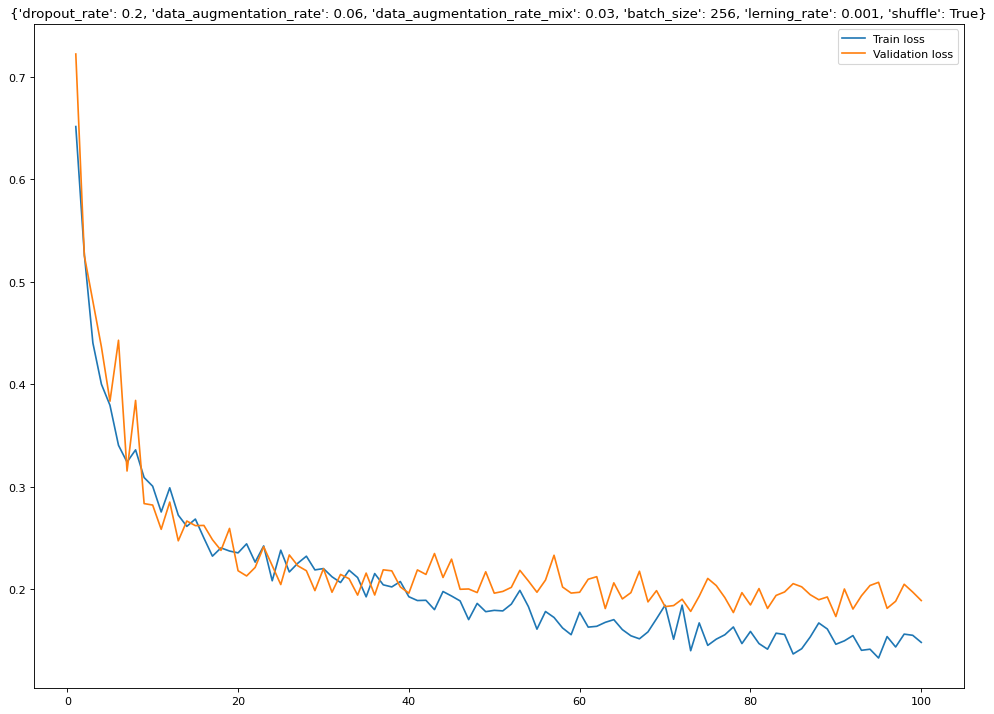

In [28]:
figure(figsize=(15,11), dpi=80)
plt.plot(range(1,101), tr_loss,label = "Train loss")
plt.plot(range(1,101), val_los, label = "Validation loss")
plt.title(hyp)
plt.legend()

In [29]:
epochs_num = np.argmin(val_los)
print("Epoch hyperparameter " + str(epochs_num))

Epoch hyperparameter 89


In [30]:
print("Best val loss")
val_los[epochs_num]

Best val loss


0.1735

In [31]:
def prediction(model,test_dataloader):
  with torch.no_grad():
    model.eval()
    prediction = np.empty([0], dtype=np.int8)


    for test_batch in tqdm(test_dataloader, desc="Testing"):
      x, _ = test_batch
      x = x.float().cuda()
      logits = model(x)
      tmp_arr = logits.argmax(dim=-1)
      prediction = np.append(prediction,tmp_arr.cpu().numpy())
  return prediction

In [32]:
cifar10_dataloader_noShuffle = DataLoader(val_datasets, batch_size=hyp["batch_size"], shuffle=False)

In [33]:
p = prediction(cnn_model5, cifar10_dataloader_noShuffle)

Testing: 100%|██████████| 40/40 [00:00<00:00, 181.20it/s]


In [34]:
p_encoded = cifar10_dataset.encodeLabel(p)
p2 = np.array([int(np.argmax(i[1])) for i in val_datasets])
p2_encoded = cifar10_dataset.encodeLabel(p2)
cm = confusion_matrix(p_encoded, p2_encoded)
cm

array([[881,  11,  57,  25,  15,   7,   3,  16,  43,  32],
       [ 11, 969,   3,   2,   1,   1,   1,   3,  13,  80],
       [ 27,   1, 726,  44,  22,  31,  14,  10,   8,   7],
       [  5,   1,  31, 614,  32, 138,  11,  22,   6,   7],
       [  5,   1,  53,  43, 785,  38,   4,  41,   5,   3],
       [  5,   0,  34,  78,  13, 683,   5,  39,   0,   2],
       [ 14,  21, 113, 171, 109, 102, 937,  37,  18,  19],
       [  4,   1,   7,  20,  18,  21,   1, 791,   1,   2],
       [ 27,   4,   8,   6,   3,   1,   1,   0, 879,  14],
       [  7,  20,   1,   2,   1,   3,   0,   4,   0, 844]])

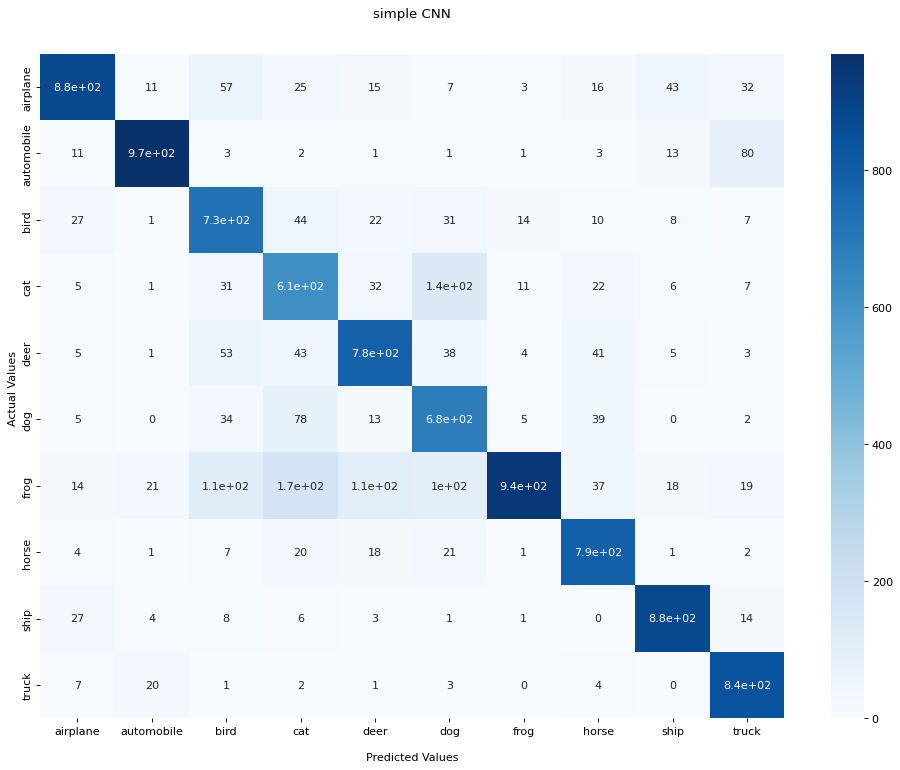

In [36]:
import seaborn as sns

figure(figsize=(15,11), dpi=80)

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('simple CNN\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(cifar10_dataset.encodeLabel(list(range(10))))
ax.yaxis.set_ticklabels(cifar10_dataset.encodeLabel(list(range(10))))

## Display the visualization of the Confusion Matrix.
plt.show()

In [37]:
from itertools import chain
from sklearn.utils import _safe_indexing

indexes = np.arange(len(cifar10_dataset))
cifar10_Whole = list(
        chain.from_iterable(
            (_safe_indexing(a, indexes)) for a in [cifar10_dataset]
        )
      )

In [38]:
cifar10_dataloader_Whole = DataLoader(cifar10_Whole, batch_size=hyp["batch_size"], shuffle=hyp["shuffle"])

In [39]:
cnn_model5.load_state_dict(init_weights)

<All keys matched successfully>

In [40]:
tr_loss, _ = train(cnn_model5, cifar10_dataloader_Whole,num_epochs=100,lr = hyp["lerning_rate"])

Training (epoch=0/100): 100%|██████████| 196/196 [00:02<00:00, 69.15it/s, loss=0.859]


Train loss 0.6311599999999999


Training (epoch=1/100): 100%|██████████| 196/196 [00:02<00:00, 65.57it/s, loss=0.832]


Train loss 0.50282


Training (epoch=2/100): 100%|██████████| 196/196 [00:02<00:00, 68.79it/s, loss=0.828]


Train loss 0.44064000000000003


Training (epoch=3/100): 100%|██████████| 196/196 [00:03<00:00, 59.81it/s, loss=0.797]


Train loss 0.39648000000000005


Training (epoch=4/100): 100%|██████████| 196/196 [00:02<00:00, 67.29it/s, loss=0.789]


Train loss 0.37417999999999996


Training (epoch=5/100): 100%|██████████| 196/196 [00:03<00:00, 63.58it/s, loss=0.898]


Train loss 0.35472000000000004


Training (epoch=6/100): 100%|██████████| 196/196 [00:02<00:00, 68.21it/s, loss=0.781]


Train loss 0.31655999999999995


Training (epoch=7/100): 100%|██████████| 196/196 [00:02<00:00, 69.16it/s, loss=0.734]


Train loss 0.30613999999999997


Training (epoch=8/100): 100%|██████████| 196/196 [00:02<00:00, 68.20it/s, loss=0.77] 


Train loss 0.28434000000000004


Training (epoch=9/100): 100%|██████████| 196/196 [00:02<00:00, 66.08it/s, loss=0.766]


Train loss 0.27571999999999997


Training (epoch=10/100): 100%|██████████| 196/196 [00:02<00:00, 69.76it/s, loss=0.746]


Train loss 0.26271999999999995


Training (epoch=11/100): 100%|██████████| 196/196 [00:02<00:00, 68.51it/s, loss=0.734]


Train loss 0.26792000000000005


Training (epoch=12/100): 100%|██████████| 196/196 [00:02<00:00, 68.00it/s, loss=0.766]


Train loss 0.26027999999999996


Training (epoch=13/100): 100%|██████████| 196/196 [00:02<00:00, 67.03it/s, loss=0.773]


Train loss 0.24470000000000003


Training (epoch=14/100): 100%|██████████| 196/196 [00:02<00:00, 67.52it/s, loss=0.754]


Train loss 0.24416000000000004


Training (epoch=15/100): 100%|██████████| 196/196 [00:03<00:00, 63.51it/s, loss=0.77] 


Train loss 0.24531999999999998


Training (epoch=16/100): 100%|██████████| 196/196 [00:03<00:00, 65.13it/s, loss=0.746]


Train loss 0.24531999999999998


Training (epoch=17/100): 100%|██████████| 196/196 [00:02<00:00, 69.18it/s, loss=0.73] 


Train loss 0.24153999999999998


Training (epoch=18/100): 100%|██████████| 196/196 [00:02<00:00, 68.57it/s, loss=0.754]


Train loss 0.23597999999999997


Training (epoch=19/100): 100%|██████████| 196/196 [00:02<00:00, 68.12it/s, loss=0.828]


Train loss 0.22858


Training (epoch=20/100): 100%|██████████| 196/196 [00:02<00:00, 65.46it/s, loss=0.75] 


Train loss 0.22109999999999996


Training (epoch=21/100): 100%|██████████| 196/196 [00:02<00:00, 69.28it/s, loss=0.734]


Train loss 0.22677999999999998


Training (epoch=22/100): 100%|██████████| 196/196 [00:02<00:00, 67.97it/s, loss=0.738]


Train loss 0.2096


Training (epoch=23/100): 100%|██████████| 196/196 [00:02<00:00, 67.88it/s, loss=0.734]


Train loss 0.20967999999999998


Training (epoch=24/100): 100%|██████████| 196/196 [00:02<00:00, 65.71it/s, loss=0.75] 


Train loss 0.20504


Training (epoch=25/100): 100%|██████████| 196/196 [00:02<00:00, 67.45it/s, loss=0.734]


Train loss 0.21197999999999995


Training (epoch=26/100): 100%|██████████| 196/196 [00:03<00:00, 62.82it/s, loss=0.738]


Train loss 0.22160000000000002


Training (epoch=27/100): 100%|██████████| 196/196 [00:02<00:00, 67.18it/s, loss=0.75] 


Train loss 0.20967999999999998


Training (epoch=28/100): 100%|██████████| 196/196 [00:02<00:00, 67.55it/s, loss=0.863] 


Train loss 0.19020000000000004


Training (epoch=29/100): 100%|██████████| 196/196 [00:02<00:00, 68.35it/s, loss=0.891]


Train loss 0.20109999999999995


Training (epoch=30/100): 100%|██████████| 196/196 [00:02<00:00, 68.08it/s, loss=0.754]


Train loss 0.19482


Training (epoch=31/100): 100%|██████████| 196/196 [00:03<00:00, 64.77it/s, loss=0.742] 


Train loss 0.19896000000000003


Training (epoch=32/100): 100%|██████████| 196/196 [00:02<00:00, 69.52it/s, loss=0.75] 


Train loss 0.18842000000000003


Training (epoch=33/100): 100%|██████████| 196/196 [00:02<00:00, 68.19it/s, loss=0.887] 


Train loss 0.18632000000000004


Training (epoch=34/100): 100%|██████████| 196/196 [00:02<00:00, 67.38it/s, loss=0.719]


Train loss 0.20096000000000003


Training (epoch=35/100): 100%|██████████| 196/196 [00:02<00:00, 66.04it/s, loss=0.738]


Train loss 0.19421999999999995


Training (epoch=36/100): 100%|██████████| 196/196 [00:02<00:00, 68.48it/s, loss=0.832] 


Train loss 0.18133999999999995


Training (epoch=37/100): 100%|██████████| 196/196 [00:03<00:00, 60.92it/s, loss=0.711]


Train loss 0.19618000000000002


Training (epoch=38/100): 100%|██████████| 196/196 [00:02<00:00, 68.87it/s, loss=0.719] 


Train loss 0.18089999999999995


Training (epoch=39/100): 100%|██████████| 196/196 [00:02<00:00, 66.61it/s, loss=0.73]  


Train loss 0.19066000000000005


Training (epoch=40/100): 100%|██████████| 196/196 [00:02<00:00, 68.51it/s, loss=0.738] 


Train loss 0.18091999999999997


Training (epoch=41/100): 100%|██████████| 196/196 [00:03<00:00, 65.24it/s, loss=0.738] 


Train loss 0.18296


Training (epoch=42/100): 100%|██████████| 196/196 [00:02<00:00, 68.94it/s, loss=0.73]  


Train loss 0.17193999999999998


Training (epoch=43/100): 100%|██████████| 196/196 [00:02<00:00, 67.10it/s, loss=0.734] 


Train loss 0.19264000000000003


Training (epoch=44/100): 100%|██████████| 196/196 [00:02<00:00, 68.82it/s, loss=0.699] 


Train loss 0.19045999999999996


Training (epoch=45/100): 100%|██████████| 196/196 [00:02<00:00, 69.13it/s, loss=0.715] 


Train loss 0.16532000000000002


Training (epoch=46/100): 100%|██████████| 196/196 [00:02<00:00, 65.76it/s, loss=0.727] 


Train loss 0.17920000000000003


Training (epoch=47/100): 100%|██████████| 196/196 [00:02<00:00, 69.44it/s, loss=0.785] 


Train loss 0.17991999999999997


Training (epoch=48/100): 100%|██████████| 196/196 [00:03<00:00, 63.94it/s, loss=0.738] 


Train loss 0.17374


Training (epoch=49/100): 100%|██████████| 196/196 [00:02<00:00, 68.86it/s, loss=0.727] 


Train loss 0.16593999999999998


Training (epoch=50/100): 100%|██████████| 196/196 [00:02<00:00, 67.00it/s, loss=0.73]  


Train loss 0.16620000000000001


Training (epoch=51/100): 100%|██████████| 196/196 [00:02<00:00, 69.45it/s, loss=0.734] 


Train loss 0.16800000000000004


Training (epoch=52/100): 100%|██████████| 196/196 [00:02<00:00, 68.48it/s, loss=0.738] 


Train loss 0.15547999999999995


Training (epoch=53/100): 100%|██████████| 196/196 [00:02<00:00, 68.15it/s, loss=0.73]  


Train loss 0.16679999999999995


Training (epoch=54/100): 100%|██████████| 196/196 [00:02<00:00, 65.93it/s, loss=0.852] 


Train loss 0.17132000000000003


Training (epoch=55/100): 100%|██████████| 196/196 [00:02<00:00, 68.87it/s, loss=0.719] 


Train loss 0.16346000000000005


Training (epoch=56/100): 100%|██████████| 196/196 [00:02<00:00, 67.96it/s, loss=0.715] 


Train loss 0.16381999999999997


Training (epoch=57/100): 100%|██████████| 196/196 [00:02<00:00, 68.20it/s, loss=0.746] 


Train loss 0.17264000000000002


Training (epoch=58/100): 100%|██████████| 196/196 [00:02<00:00, 66.14it/s, loss=0.801] 


Train loss 0.15898


Training (epoch=59/100): 100%|██████████| 196/196 [00:02<00:00, 68.54it/s, loss=0.719] 


Train loss 0.15525999999999995


Training (epoch=60/100): 100%|██████████| 196/196 [00:03<00:00, 64.02it/s, loss=0.723] 


Train loss 0.19054000000000004


Training (epoch=61/100): 100%|██████████| 196/196 [00:02<00:00, 67.34it/s, loss=0.707] 


Train loss 0.15980000000000005


Training (epoch=62/100): 100%|██████████| 196/196 [00:02<00:00, 68.54it/s, loss=0.719] 


Train loss 0.15925999999999996


Training (epoch=63/100): 100%|██████████| 196/196 [00:02<00:00, 68.82it/s, loss=0.73]  


Train loss 0.16942000000000002


Training (epoch=64/100): 100%|██████████| 196/196 [00:02<00:00, 68.26it/s, loss=0.727] 


Train loss 0.17156000000000005


Training (epoch=65/100): 100%|██████████| 196/196 [00:03<00:00, 64.96it/s, loss=0.715] 


Train loss 0.15322000000000002


Training (epoch=66/100): 100%|██████████| 196/196 [00:02<00:00, 69.71it/s, loss=0.715] 


Train loss 0.14388


Training (epoch=67/100): 100%|██████████| 196/196 [00:02<00:00, 68.30it/s, loss=0.707] 


Train loss 0.15718


Training (epoch=68/100): 100%|██████████| 196/196 [00:02<00:00, 67.82it/s, loss=0.738] 


Train loss 0.17723999999999995


Training (epoch=69/100): 100%|██████████| 196/196 [00:02<00:00, 66.12it/s, loss=0.73]  


Train loss 0.15880000000000005


Training (epoch=70/100): 100%|██████████| 196/196 [00:02<00:00, 69.56it/s, loss=0.742] 


Train loss 0.16859999999999997


Training (epoch=71/100): 100%|██████████| 196/196 [00:03<00:00, 62.11it/s, loss=0.715] 


Train loss 0.17352


Training (epoch=72/100): 100%|██████████| 196/196 [00:02<00:00, 69.30it/s, loss=0.758] 


Train loss 0.14715999999999996


Training (epoch=73/100): 100%|██████████| 196/196 [00:02<00:00, 66.55it/s, loss=0.715] 


Train loss 0.14488


Training (epoch=74/100): 100%|██████████| 196/196 [00:02<00:00, 68.50it/s, loss=0.719] 


Train loss 0.15022000000000002


Training (epoch=75/100): 100%|██████████| 196/196 [00:02<00:00, 68.32it/s, loss=0.723] 


Train loss 0.1633


Training (epoch=76/100): 100%|██████████| 196/196 [00:02<00:00, 69.13it/s, loss=0.859] 


Train loss 0.15624000000000005


Training (epoch=77/100): 100%|██████████| 196/196 [00:03<00:00, 61.76it/s, loss=0.777] 


Train loss 0.14749999999999996


Training (epoch=78/100): 100%|██████████| 196/196 [00:02<00:00, 69.72it/s, loss=0.734] 


Train loss 0.15046000000000004


Training (epoch=79/100): 100%|██████████| 196/196 [00:02<00:00, 69.17it/s, loss=0.734] 


Train loss 0.17190000000000005


Training (epoch=80/100): 100%|██████████| 196/196 [00:03<00:00, 65.20it/s, loss=0.812] 


Train loss 0.15815999999999997


Training (epoch=81/100): 100%|██████████| 196/196 [00:02<00:00, 68.77it/s, loss=0.707] 


Train loss 0.15844000000000003


Training (epoch=82/100): 100%|██████████| 196/196 [00:02<00:00, 65.92it/s, loss=0.715] 


Train loss 0.14888


Training (epoch=83/100): 100%|██████████| 196/196 [00:02<00:00, 67.50it/s, loss=0.703] 


Train loss 0.13104000000000005


Training (epoch=84/100): 100%|██████████| 196/196 [00:02<00:00, 66.55it/s, loss=0.719] 


Train loss 0.14173999999999998


Training (epoch=85/100): 100%|██████████| 196/196 [00:02<00:00, 68.66it/s, loss=0.719] 


Train loss 0.13590000000000002


Training (epoch=86/100): 100%|██████████| 196/196 [00:02<00:00, 68.19it/s, loss=0.723] 


Train loss 0.15158000000000005


Training (epoch=87/100): 100%|██████████| 196/196 [00:02<00:00, 68.16it/s, loss=0.715] 


Train loss 0.14678000000000002


Training (epoch=88/100): 100%|██████████| 196/196 [00:02<00:00, 66.39it/s, loss=0.727] 


Train loss 0.13446000000000002


Training (epoch=89/100): 100%|██████████| 196/196 [00:02<00:00, 68.51it/s, loss=0.711] 


Train loss 0.14405999999999997


Training (epoch=90/100): 100%|██████████| 196/196 [00:02<00:00, 67.97it/s, loss=0.711] 


Train loss 0.15642


Training (epoch=91/100): 100%|██████████| 196/196 [00:02<00:00, 68.20it/s, loss=0.902] 


Train loss 0.14346000000000003


Training (epoch=92/100): 100%|██████████| 196/196 [00:02<00:00, 65.66it/s, loss=0.719] 


Train loss 0.14436000000000004


Training (epoch=93/100): 100%|██████████| 196/196 [00:02<00:00, 68.82it/s, loss=0.727] 


Train loss 0.13836000000000004


Training (epoch=94/100): 100%|██████████| 196/196 [00:03<00:00, 62.39it/s, loss=0.719] 


Train loss 0.14717999999999998


Training (epoch=95/100): 100%|██████████| 196/196 [00:02<00:00, 66.93it/s, loss=0.711] 


Train loss 0.15008


Training (epoch=96/100): 100%|██████████| 196/196 [00:02<00:00, 68.59it/s, loss=0.723] 


Train loss 0.14344


Training (epoch=97/100): 100%|██████████| 196/196 [00:02<00:00, 68.12it/s, loss=0.711] 


Train loss 0.14248000000000005


Training (epoch=98/100): 100%|██████████| 196/196 [00:02<00:00, 68.29it/s, loss=0.715] 


Train loss 0.13971999999999996


Training (epoch=99/100): 100%|██████████| 196/196 [00:02<00:00, 67.10it/s, loss=0.723] 

Train loss 0.139


In [46]:
cifar10_dataset_test = CustomImageDataset("./test/")

In [47]:
test_dataloader = DataLoader(cifar10_dataset_test, batch_size=hyp["batch_size"], shuffle=False)


In [48]:
 p_test = prediction(cnn_model5, test_dataloader)

Testing: 100%|██████████| 1172/1172 [01:08<00:00, 17.14it/s]


In [49]:
def preview(datasets,encoder, labels = None,index = None):
  if index is not None:
    figure(figsize=(8, 6), dpi=80)
    img, label = datasets[index]
    if labels is not None:
      label = labels[index]
    plt.imshow(img.int().T)
    plt.show()
    print(encoder([label]))
    print()
    return

  visited = []

  for i, data in enumerate(datasets): 
    img, label = data
    if labels is not None:
      label = labels[i]
    if label in visited:
      continue
    figure(figsize=(8, 6), dpi=80)
    plt.imshow(img.int().T)
    plt.show()
    print(encoder([label]))
    print()
    visited.append(label)
    if len(visited) >= 10:
      break
    
    

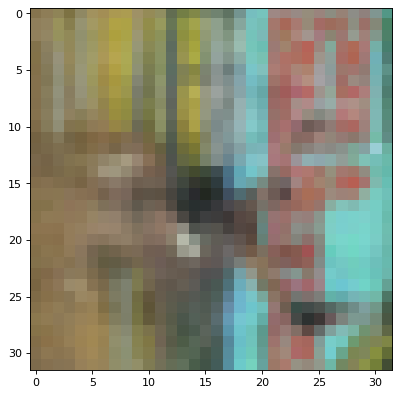

['deer']



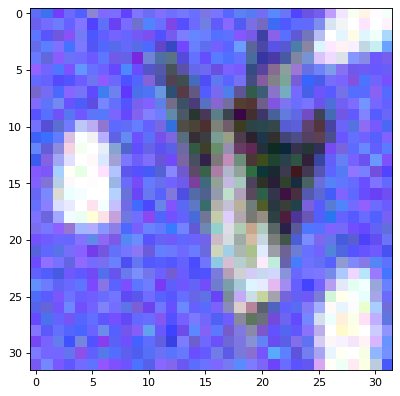

['airplane']



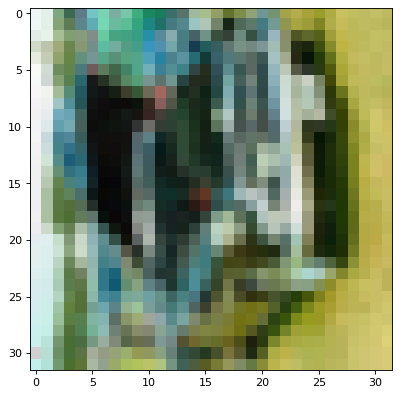

['automobile']



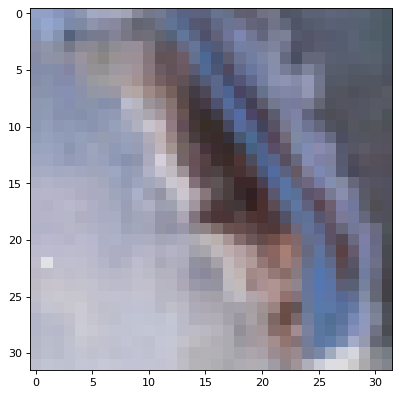

['ship']



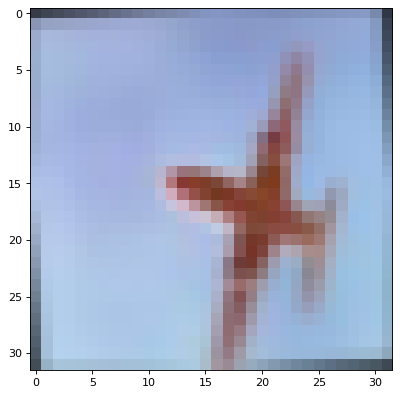

['bird']



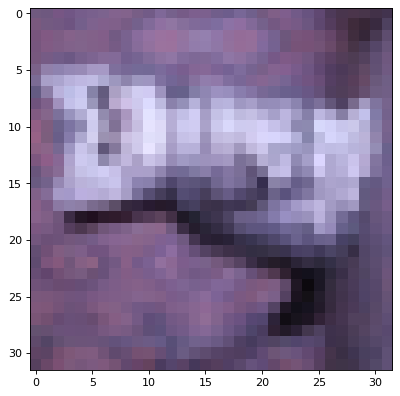

['cat']



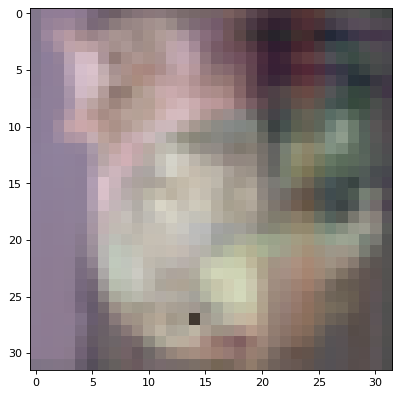

['dog']



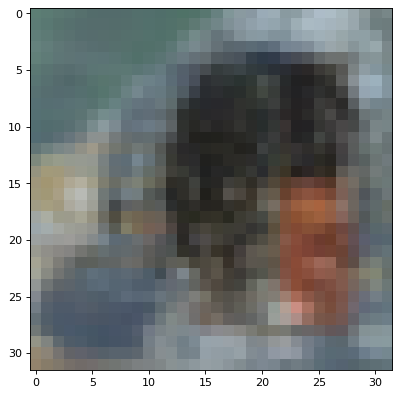

['frog']



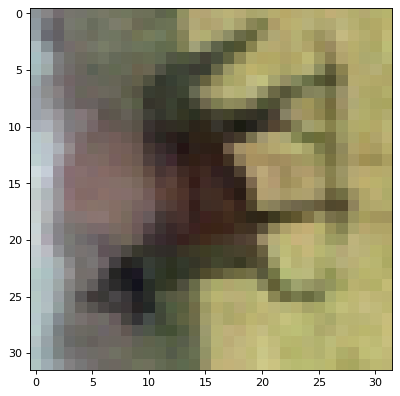

['horse']



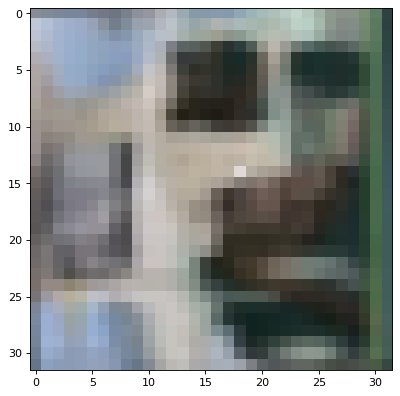

['truck']



In [50]:
preview(cifar10_dataset_test,lambda x: cifar10_dataset.encodeLabel(x),p_test)

In [51]:
df = pd.DataFrame(data=cifar10_dataset.encodeLabel(p_test))
df.columns = ["label"]
df.index += 1 

In [52]:
df.to_csv('submission.csv', index=True, index_label="id")

In [ ]:
#!kaggle competitions submit -c cifar-10 -f ../kaggle/working/submission.csv -m "Deep Learning, PW, First try"

